**Import libraries**


In [1]:
import sys
print(sys.executable)
import numpy as np
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
import cartopy.crs as ccrs
from matplotlib import gridspec
import requests
import tempfile

/usr/sbin/python


**Note：Data Preprocessing**

The selected data files are quite large, so this data preprocessing was carried out on a local computer.（The detailed processing code can be found in the file: Data Preprocessing (Run Locally).ipynb.）


In [2]:
base_url = "https://github.com/shenyuanxin19/enso_gpp/raw/main/"

def download_temp(url):
    with tempfile.NamedTemporaryFile(suffix='.nc', delete=False) as tmp:
        r = requests.get(url, timeout=60)
        r.raise_for_status()
        tmp.write(r.content)
        return tmp.name

# **step.1 ENSO Index Calculation and Visualization**

In [3]:
FILES = {
    "abrupt-4xCO2": "tos_Omon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1_1890-1949_detrend.nc",
    "G1": "tos_Omon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend.nc",
    "piControl": "tos_Omon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend.nc",
}

(1) Calculation of the ENSO Index:
We used the standardized anomaly of the December–February (DJF) mean sea surface temperature (SST) over the Niño3.4 region (5°N–5°S, 170°W–120°W) as the ENSO indicator.
The Niño3.4 region best captures the core strength of ENSO events, while DJF represents the season when the ENSO signal is most mature and its climatic impacts are strongest. The standardization ensures comparability across different years and models.

a. We extracted SST (tos) from the equatorial central–eastern Pacific Niño3.4 region (latitude 5°N–5°S, longitude 170°W–120°W).

b. We computed the area-averaged SST for each December–February season, then removed the long-term climatological mean to obtain the DJF SST anomalies for each year.

c. These anomalies were standardized (subtracting the mean and dividing by the standard deviation) to derive the final standardized Niño3.4 index.

A positive Niño3.4 index indicates an El Niño event (warming in the central–eastern Pacific), while a negative value represents a La Niña event (cooling anomaly).
The larger the absolute value, the stronger the event. This method allows for an accurate and objective assessment of the relative strength and variability of each ENSO episode.

In [4]:
# Define Niño3.4 region boundaries
lat_bounds = (-5, 5)    #5°N–5°S
lon_bounds = (190, 240) #170°W–120°W

# Define function to calculate ENSO index
def calc_djf_index(ds):
    tos = ds['tos']
    tos_sel = tos.sel(lat=slice(*lat_bounds), lon=slice(*lon_bounds))
    tos_mean = tos_sel.mean(dim=('lat', 'lon'))

    # DJF season mean
    djf = tos_mean.rolling(time=3, center=True).mean()
    djf = djf.sel(time=djf['time.month'] == 1)
    djf = djf.sel(time=slice('1890-01-01', '1949-12-31'))

    values = djf.values
    #values = (values - np.nanmean(values)) / np.nanstd(values) # Standardize ENSO index
    values = (values - np.nanmean(values))
    return values, djf['time'].dt.year.values

ENSO_index = np.zeros((3, 60)) #Store ENSO indices for three scenarios
years = None
for k, fname in enumerate(FILES.values()):
    tmp_path = download_temp(base_url + fname)
    ds = xr.open_dataset(tmp_path)
    values, yrs = calc_djf_index(ds)
    Path(tmp_path).unlink()  # Cleaning up temporary files
    ENSO_index[k, :] = values
    if years is None:
        years = yrs
    ds.close()

print('ENSO_index shape:', ENSO_index.shape)

getfattr: /tmp/tmpq7bpuurv.nc: Operation not supported
getfattr: /tmp/tmpiro57ok9.nc: Operation not supported
getfattr: /tmp/tmpqp1js7_g.nc: Operation not supported


ENSO_index shape: (3, 60)


(2) Plotting the Year-to-Year Variability of the ENSO Index
We visualized the annual fluctuations of the ENSO index to compare the event intensities among the three scenarios—abrupt-4xCO₂, G1, and piControl.
This provides a clear background for understanding how ENSO modulates the sensitivity of terrestrial carbon fluxes (GPP) in tropical regions under different forcing conditions.

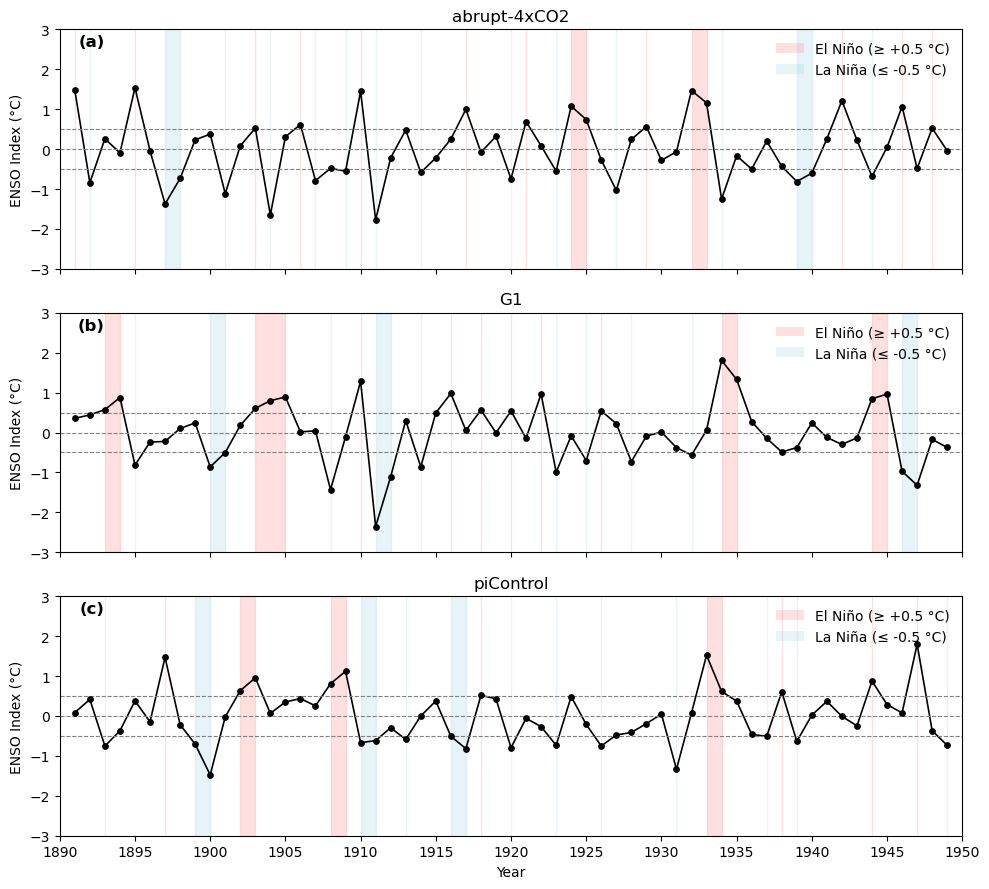

In [5]:
# plot
fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=True)

for i, (exp, fname) in enumerate(FILES.items()):
    ax = axes[i]
    vals = ENSO_index[i, :]
    
    ax.fill_between(years, -5, 5, where=vals > 0.5, color='#FF9999', alpha=0.3)  # ENSO index ≥ +0.5 → El Niño (warm phase)
    ax.fill_between(years, -5, 5, where=vals < -0.5, color='#ADD8E6', alpha=0.3) # ENSO index ≤ -0.5 → La Niña (cold phase)
    ax.plot(years, vals, color='black', linewidth=1.2)
    ax.scatter(years, vals, color='black', s=15, zorder=3)

    # y = 0 represents climatological equilibrium; ±0.5 marks ENSO thresholds
    ax.axhline(0, color='gray', linewidth=0.8, linestyle='--')
    ax.axhline(0.5, color='gray', linewidth=0.8, linestyle='--')
    ax.axhline(-0.5, color='gray', linewidth=0.8, linestyle='--')

    ax.set_ylim(-3, 3)
    ax.set_ylabel('ENSO Index (°C)')
    ax.set_title(exp)
    
    ax.text(0.05, 0.98, f'({chr(97+i)})', transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top', ha='right')
    # legend
    legend_handles = [
        Patch(facecolor='#FF9999', alpha=0.3, label='El Niño (≥ +0.5 °C)'),
        Patch(facecolor='#ADD8E6', alpha=0.3, label='La Niña (≤ -0.5 °C)')
    ]
    ax.legend(handles=legend_handles, loc='upper right', frameon=False)

axes[-1].set_xlabel('Year')
axes[-1].set_xlim(1890, 1950)
axes[-1].set_xticks(np.arange(1890, 1951, 5))

plt.tight_layout()

plt.savefig('DJF_Nino34_1890-1949.png', dpi=300, bbox_inches='tight')
plt.show()

This figure first shows variations in the ENSO index under three climate scenarios: pre-industrial (piControl), strong warming (abrupt-4×CO₂), and geoengineering (G1). 

We can see that ENSO intensity and frequency remain relatively consistent across all three scenarios. This means if we later observe changes in plant carbon uptake (GPP), those changes are not due to variations in ENSO strength itself, but instead reflect how sensitive the ecosystem has become to ENSO events.


# **step.2 Interannual Variations of Tropical Terrestrial Carbon Flux (GPP)**

We plotted the interannual variability of terrestrial carbon flux (GPP) in the tropical region (40°S–40°N) to illustrate the year-to-year trends under different climate scenarios (piControl, abrupt-4xCO₂, G1).
This comparison highlights both the short-term fluctuations and long-term trends of tropical GPP, providing essential context for further investigating how ENSO influences GPP responses.

Land Area Corresponding to Each 1°×1° Grid Cell
We matched the land area data to the GPP grid to ensure their latitude–longitude coordinates are perfectly aligned.

In [6]:
GPP_FILES = {
    'abrupt-4xCO2':  'gpp_Lmon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1_1890-1949_detrend.nc',
    'G1': 'gpp_Lmon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend.nc',
    'piControl': 'gpp_Lmon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend.nc'
}

AREA_FILE = 'landarea_1x1.nc'   #matched the land area data to the GPP grid to ensure their latitude–longitude coordinates are perfectly aligned.
LAT_SLICE = slice(-40, 40)

In [7]:
# Match land area data to the GPP grid so that both share identical lat/lon coordinates
def standardize_coords(ds):
    if 'latitude' in ds.coords: ds = ds.rename({'latitude': 'lat'})
    if 'longitude' in ds.coords: ds = ds.rename({'longitude': 'lon'})
    if 'lon' in ds.coords and float(ds['lon'].min()) < 0:
        ds = ds.assign_coords(lon=(ds['lon'] % 360)).sortby('lon')
    return ds

# Build area data on the same grid as GPP
def build_area_on_gpp_grid(area_path, gpp_ref_da):
    ds_area = xr.open_dataset(area_path) if isinstance(area_path, str) else xr.open_dataset(area_path)
    if 'area' not in ds_area.data_vars:
        if len(ds_area.data_vars) == 1:
            only = list(ds_area.data_vars)[0]
            ds_area = ds_area.rename({only: 'area'})
        else:
            raise KeyError('fsil find vars \'area\'')
    ds_area = standardize_coords(ds_area)
    area = ds_area['area'].sel(lat=LAT_SLICE)
    area_matched = area.interp(lat=gpp_ref_da.lat, lon=gpp_ref_da.lon, method='nearest') # Use nearest-neighbor interpolation to match area data to GPP grid
    return area_matched.broadcast_like(gpp_ref_da.isel(time=0))

Calculation of Annual Total GPP in the Tropical Region

We first calculated the total carbon uptake for each month and each grid cell based on the grid-level GPP rate (unit: kg C m⁻² s⁻¹).

Step 1: Multiply the GPP rate (kg C m⁻² s⁻¹) by the corresponding land area of each grid cell (km², converted to m² by multiplying 10⁶), and then by the total number of seconds in that month (days × 86400). This yields the monthly total carbon uptake (kg C) for each grid cell.

Step 2: Sum the results across all grid cells to obtain the regional total carbon uptake (kg C) for each month. To better represent large-scale carbon fluxes, the unit is converted from kilograms to petagrams of carbon (PgC, where 1 PgC = 10¹² kg C) by multiplying by 10⁻¹².

Step 3: Finally, sum up all twelve monthly totals to obtain the annual total carbon uptake (PgC yr⁻¹) for the entire tropical region (40°S–40°N).

In [8]:
# Calculate total annual GPP flux (PgC/yr) for the study region (40°S–40°N)
def compute_annual_gpp_total(gpp_path, area_matched):
    ds = xr.open_dataset(gpp_path)
    ds = standardize_coords(ds)
    if 'gpp' not in ds.data_vars:
        only = list(ds.data_vars)[0]
        ds = ds.rename({only: 'gpp'})
    gpp = ds['gpp'].sel(lat=LAT_SLICE)

    area_use = area_matched.sel(lat=gpp.lat, lon=gpp.lon)
    area_use = xr.where(gpp.isel(time=0).isnull(), 0.0, area_use)
    days_in_month = gpp['time'].dt.days_in_month
    monthly_total = (gpp * area_use * days_in_month * 86400).sum(('lat','lon')) * 1e-12 * 1e6 # unit conversion to PgC
    annual_total = monthly_total.resample(time='YS').sum().sel(time=slice('1890','1949'))
    return annual_total


tmp = download_temp(base_url + 'gpp_Lmon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend.nc')
gpp_ref = xr.open_dataset(tmp)['gpp']
Path(tmp).unlink()

tmp = download_temp(base_url + 'landarea_1x1.nc')
area_ref = build_area_on_gpp_grid(tmp, gpp_ref)
Path(tmp).unlink()

GPP_totals = {}
for exp, fname in GPP_FILES.items():
    tmp = download_temp(base_url + fname.name if hasattr(fname, 'name') else base_url + fname.split('/')[-1])
    ann = compute_annual_gpp_total(tmp, area_ref)
    Path(tmp).unlink()
    GPP_totals[exp] = ann.values  # PgC/yr
years = ann['time.year'].values  # total of 60 years

getfattr: /tmp/tmpq5lxhtdk.nc: Operation not supported
getfattr: /tmp/tmpd1amg60e.nc: Operation not supported
getfattr: /tmp/tmpqfd5y3pk.nc: Operation not supported
getfattr: /tmp/tmpschk3vr4.nc: Operation not supported


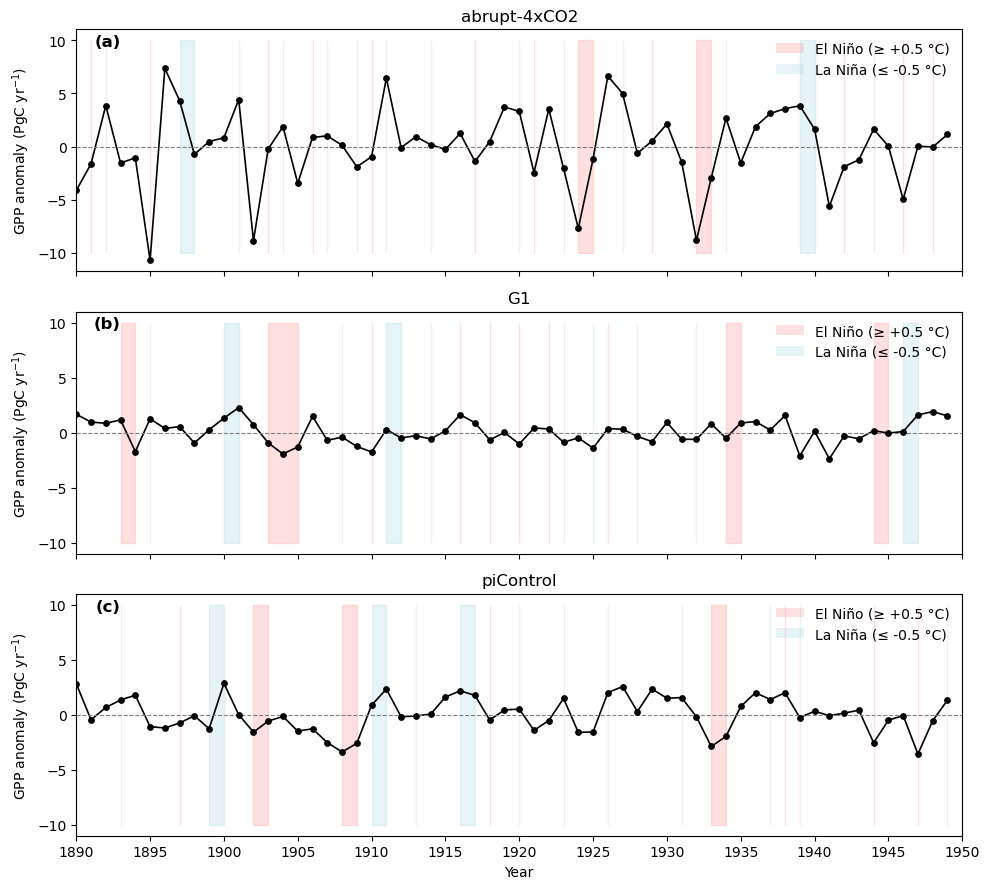

In [9]:
# plot
fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=True)

for i, (exp, gpp_vals) in enumerate(GPP_totals.items()):
    ax = axes[i]
    enso_vals = ENSO_index[i, :]   
    ax.fill_between(years, -10, 10, where=enso_vals >= 0.5, color='#FF9999', alpha=0.3)
    ax.fill_between(years, -10, 10, where=enso_vals <= -0.5, color='#ADD8E6', alpha=0.3)

    ax.plot(years, gpp_vals, color='black', linewidth=1.2)
    ax.scatter(years, gpp_vals, color='black', s=15, zorder=3)
    
    ax.axhline(0, color='gray', linewidth=0.8, linestyle='--')
    ax.set_ylabel('GPP anomaly (PgC yr$^{-1}$)')
    ax.set_title(exp)
    ax.text(0.05, 0.98, f'({chr(97+i)})', transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top', ha='right')

    legend_handles = [
        Patch(facecolor='#FF9999', alpha=0.3, label='El Niño (≥ +0.5 °C)'),
        Patch(facecolor='#ADD8E6', alpha=0.3, label='La Niña (≤ -0.5 °C)')
    ]
    ax.legend(handles=legend_handles, loc='upper right', frameon=False)

axes[-1].set_xlabel('Year')
axes[-1].set_xlim(1890, 1950)
axes[-1].set_xticks(np.arange(1890, 1951, 5))

plt.tight_layout()

plt.savefig('GPP_anomalies_40S40N_1890-1949.png', dpi=300, bbox_inches='tight')
plt.show()

This figure further shows the year-to-year variations in terrestrial carbon uptake (GPP) under different scenarios. We find that even though the strength of ENSO itself remains stable across scenarios, the year-to-year fluctuations in GPP become much stronger under the high-temperature, high-CO₂ scenario (abrupt-4×CO₂). This means the same intensity of ENSO events causes larger disruptions to GPP in a warmer climate.

In contrast, under the geoengineering scenario (G1), GPP fluctuations significantly decrease, approaching the pre-industrial (piControl) level. In other words, geoengineering measures effectively reduce the sensitivity of terrestrial ecosystems to ENSO events, significantly minimizing disruptions to plant carbon uptake.

# **step.3 Sensitivity Analysis of Tropical Carbon Flux to ENSO**

We quantitatively assessed how tropical terrestrial carbon flux (GPP) responds to ENSO variability under different climate scenarios by computing regression coefficients between the GPP anomalies and the ENSO index.


Bar charts were then plotted to clearly display the differences and statistical significance among the three experiments (abrupt-4xCO₂, G1, and piControl).

This analysis allows us to explicitly identify how the strength of ENSO’s impact on land carbon uptake differs across various climate forcing conditions.

In [10]:
# ENSO_index: shape (3, 60) – ENSO indices for the three scenarios
# GPP_totals: dict – interannual GPP variations (PgC/yr) for the three scenarios
exp_names = ['abrupt-4xCO2', 'G1', 'piControl']
GPP_array = np.vstack([GPP_totals[exp] for exp in exp_names])  # Convert GPP_totals into an array with shape (3, 60)

In [11]:
# Define function to calculate regression coefficient
def calc_regression_coef(x, y):
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() > 1:
        return np.cov(x[mask], y[mask], ddof=1)[0, 1] / np.var(x[mask], ddof=1)
    else:
        return np.nan

#  Bootstrap confidence interval estimation 
n_boot = 5000
rng = np.random.default_rng(seed=42)

# Compute regression coefficients and confidence intervals for each scenario
betas = []
ci_lows = []
ci_highs = []

for i in range(3):
    x = ENSO_index[i, :]
    y = GPP_array[i, :]
    
    # Calculate regression coefficient (sensitivity)
    beta = calc_regression_coef(x, y)
    betas.append(beta)
    
    # Bootstrap resampling to estimate 95% confidence interval
    mask = np.isfinite(x) & np.isfinite(y)
    x_valid, y_valid = x[mask], y[mask]
    n = len(x_valid)
    
    boot_betas = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        boot_betas.append(calc_regression_coef(x_valid[idx], y_valid[idx]))
    
    ci_low, ci_high = np.percentile(boot_betas, [2.5, 97.5])
    ci_lows.append(ci_low)
    ci_highs.append(ci_high)

betas = np.array(betas)
yerr = np.vstack([betas - np.array(ci_lows), np.array(ci_highs) - betas])
print(betas)

[-2.91213562 -0.18242003 -1.60514598]


In [12]:
# Estimating Sensitivity Differences Between Scenarios
pairs = [
    ("abrupt-4xCO2", "piControl"),
    ("G1", "abrupt-4xCO2"),  
    ("G1", "piControl")
]

pair_labels = [f"{a} – {b}" for a, b in pairs]
diff_means = []
diff_err_low = []
diff_err_high = []

for expA, expB in pairs:
    iA = exp_names.index(expA)
    iB = exp_names.index(expB)
    
    xA, yA = ENSO_index[iA, :], GPP_array[iA, :]
    xB, yB = ENSO_index[iB, :], GPP_array[iB, :]
    
    # differences in ENSO–GPP sensitivity among the three climate experiments using bootstrap resampling.
    maskA = np.isfinite(xA) & np.isfinite(yA)
    maskB = np.isfinite(xB) & np.isfinite(yB)
    xA_v, yA_v = xA[maskA], yA[maskA]
    xB_v, yB_v = xB[maskB], yB[maskB]
    
    boot_diffs = []
    for _ in range(n_boot):
        idxA = rng.integers(0, len(xA_v), len(xA_v))
        idxB = rng.integers(0, len(xB_v), len(xB_v))
        betaA = calc_regression_coef(xA_v[idxA], yA_v[idxA])
        betaB = calc_regression_coef(xB_v[idxB], yB_v[idxB])
        boot_diffs.append(betaA - betaB)
    
    mean_diff = np.nanmean(boot_diffs)
    ci_low, ci_high = np.percentile(boot_diffs, [2.5, 97.5])
    
    diff_means.append(mean_diff)
    diff_err_low.append(mean_diff - ci_low)
    diff_err_high.append(ci_high - mean_diff)

diff_yerr = np.vstack([diff_err_low, diff_err_high])

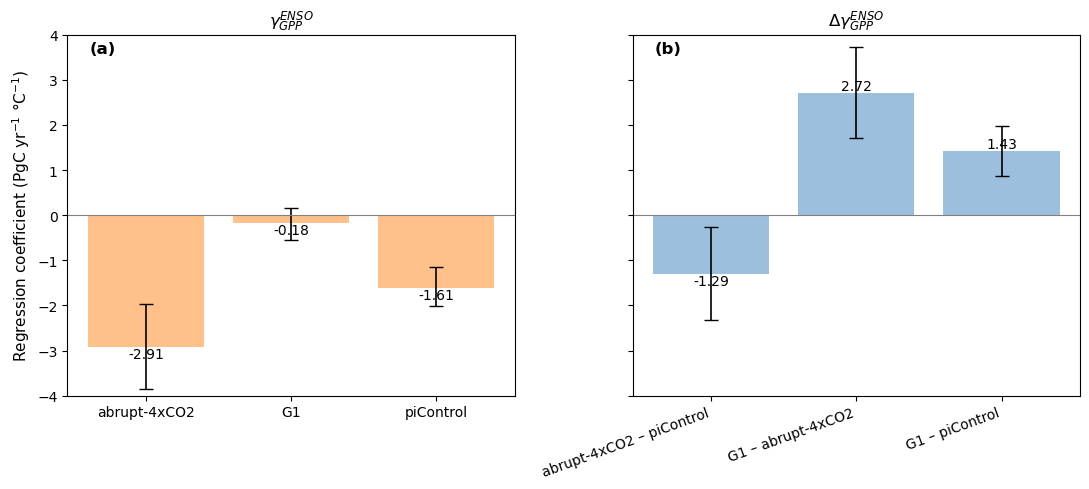

In [13]:
# plot
colors_coeff = ['#FFB574', '#FFB574', '#FFB574']  # light orange for regression coefficients
colors_diff = ['#8CB4D9', '#8CB4D9', '#8CB4D9']   #  light blue for sensitivity differences


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5), sharey=True)

# (a): Regression Coefficients Across Scenarios
bars1 = ax1.bar(exp_names, betas, yerr=yerr,
                color=colors_coeff, alpha=0.85, capsize=5, 
                error_kw=dict(lw=1.2))

for bar, val in zip(bars1, betas):
    ax1.text(bar.get_x() + bar.get_width()/2, val,
             f'{val:.2f}', ha='center', 
             va='bottom' if val >= 0 else 'top', fontsize=10)

ax1.axhline(0, color='gray', lw=0.8)
ax1.set_title(r'$\gamma_{GPP}^{ENSO}$', fontsize=12)
ax1.set_ylabel('Regression coefficient (PgC yr$^{-1}$ °C$^{-1}$)', fontsize=11)
ax1.set_ylim(-4, 4)
ax1.text(0.05, 0.95, '(a)', transform=ax1.transAxes, 
         fontsize=12, fontweight='bold')

# (b): Differences in Regression Coefficients Between Scenarios
bars2 = ax2.bar(range(len(pair_labels)), diff_means, yerr=diff_yerr,
                color=colors_diff, alpha=0.85, capsize=5,
                error_kw=dict(lw=1.2))

for bar, val in zip(bars2, diff_means):
    ax2.text(bar.get_x() + bar.get_width()/2, val,
             f'{val:.2f}', ha='center',
             va='bottom' if val >= 0 else 'top', fontsize=10)

ax2.axhline(0, color='gray', lw=0.8)
ax2.set_title(r'$\Delta \gamma_{GPP}^{ENSO}$', fontsize=12)
ax2.set_xticks(range(len(pair_labels)))
ax2.set_xticklabels(pair_labels, rotation=20, ha='right')
ax2.text(0.05, 0.95, '(b)', transform=ax2.transAxes,
         fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('GPP_ENSO_sensitivity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

This figure shows the sensitivity of GPP to ENSO (regression coefficients) across the three scenarios. 

Panel (a) illustrates that the negative sensitivity is strongest under the abrupt-4×CO₂ scenario (−2.91 PgC yr⁻¹ °C⁻¹), highlighting a significantly enhanced negative impact of ENSO on GPP under high CO₂ conditions. 
In contrast, the sensitivity under the G1 scenario is weakest (−0.18 PgC yr⁻¹ °C⁻¹), indicating that SRM geoengineering effectively reduces the negative impact of ENSO on terrestrial carbon fluxes. 

Panel (b) further quantifies and confirms this conclusion by demonstrating a significant decrease in GPP sensitivity in the G1 scenario compared to the abrupt-4×CO₂ scenario.

# **step.4 Spatial Sensitivity Analysis**

Then we mapped the spatial distribution of GPP sensitivity to ENSO to visualize how different tropical regions respond under varying climate conditions.
This spatial perspective helps clarify regional contrasts in ENSO responses and highlights potential ecological impacts under geoengineering scenarios.


In [14]:
GPP_FILES = {
    'abrupt-4xCO2': 'gpp_Lmon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1_1890-1949_detrend.nc',
    'G1': 'gpp_Lmon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend.nc',
    'piControl': 'gpp_Lmon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend.nc',
}

In [15]:
# Calculate spatial regression coefficients

def compute_annual_gpp_field(gpp_path):

    ds = xr.open_dataset(gpp_path)
    ds = standardize_coords(ds)
    var = 'gpp' if 'gpp' in ds.data_vars else list(ds.data_vars)[0]
    gpp = ds[var].sel(lat=LAT_SLICE)
    
    days = gpp['time'].dt.days_in_month
    gpp_annual = (gpp * days * 86400).resample(time='YS').sum()
    gpp_annual = gpp_annual.sel(time=slice('1890','1949'))
    
    return gpp_annual.astype('float32')

# Define and Visualize Spatial Sensitivity of GPP to ENSO
def calc_spatial_regression(gpp_annual_da, enso_series):
    gpp = gpp_annual_da.values
    t, nlat, nlon = gpp.shape
    betas = np.full((nlat, nlon), np.nan, dtype='float32')
    
    for i in range(nlat):
        for j in range(nlon):
            y = gpp[:, i, j]
            if np.all(np.isnan(y)): 
                continue
            
            mask = np.isfinite(enso_series) & np.isfinite(y)
            if mask.sum() > 1:
                betas[i, j] = np.cov(enso_series[mask], y[mask], ddof=1)[0, 1] / np.var(enso_series[mask], ddof=1)
    
    return betas


GPP_annual = {}
for exp, fname in GPP_FILES.items():
    tmp = download_temp(base_url + fname)
    da = compute_annual_gpp_field(tmp)
    Path(tmp).unlink()
    print(f'{exp}: shape={da.shape}')
    GPP_annual[exp] = da
    
# Calculate spatial regression coefficients
exp_order = ['abrupt-4xCO2', 'G1', 'piControl']
beta_maps = {}

for i, exp in enumerate(exp_order):
    betas = calc_spatial_regression(GPP_annual[exp], ENSO_index[i, :])
    beta_maps[exp] = betas
    print(f'{exp} beta range: [{np.nanmin(betas):.3f}, {np.nanmax(betas):.3f}]')

# Calculate differences
diff_maps = {
    'abrupt-4xCO2 − piControl': beta_maps['abrupt-4xCO2'] - beta_maps['piControl'],
    'G1 − abrupt-4xCO2': beta_maps['G1'] - beta_maps['abrupt-4xCO2'],
    'G1 − piControl': beta_maps['G1'] - beta_maps['piControl']
}

getfattr: /tmp/tmpipe833yk.nc: Operation not supported
getfattr: /tmp/tmpwzlpca3y.nc: Operation not supported
getfattr: /tmp/tmpuhanbc_8.nc: Operation not supported


abrupt-4xCO2: shape=(60, 81, 360)
G1: shape=(60, 81, 360)
piControl: shape=(60, 81, 360)
abrupt-4xCO2 beta range: [-0.385, 0.182]
G1 beta range: [-0.216, 0.352]
piControl beta range: [-0.248, 0.326]


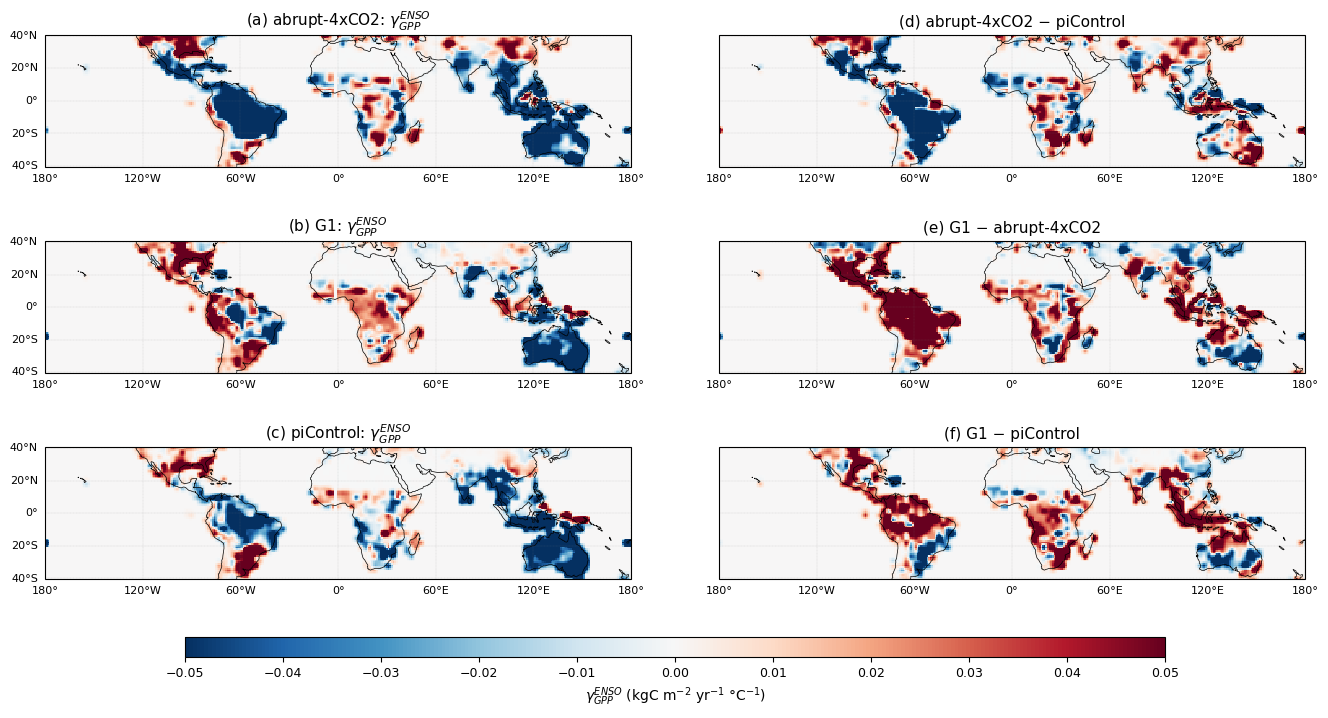

In [16]:
#  Plot spatial distribution maps
fig = plt.figure(figsize=(14, 10))
positions = [
    (0, 0), (1, 0),  # a, d
    (0, 1), (1, 1),  # b, e  
    (0, 2), (1, 2)   # c, f
]

left_data = [beta_maps['abrupt-4xCO2'], beta_maps['G1'], beta_maps['piControl']]
right_data = list(diff_maps.values())

left_titles = [
    r'(a) abrupt-4xCO2: $\gamma_{GPP}^{ENSO}$',
    r'(b) G1: $\gamma_{GPP}^{ENSO}$', 
    r'(c) piControl: $\gamma_{GPP}^{ENSO}$'
]

right_titles = [
    r'(d) abrupt-4xCO2 − piControl',
    r'(e) G1 − abrupt-4xCO2',
    r'(f) G1 − piControl'
]

vmin, vmax = -0.05, 0.05

axes = []
for i in range(3):
    # Left panel
    ax_left = plt.subplot(3, 2, i*2 + 1, projection=ccrs.PlateCarree())
    im = ax_left.pcolormesh(
        GPP_annual['abrupt-4xCO2'].lon.values,
        GPP_annual['abrupt-4xCO2'].lat.values,
        left_data[i],
        cmap='RdBu_r', vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree()
    )
    ax_left.coastlines(linewidth=0.5)
    ax_left.set_title(left_titles[i], fontsize=11)
    
    # Add latitude and longitude grid
    gl_left = ax_left.gridlines(draw_labels=True, linewidth=0.2, 
                                color='gray', alpha=0.5, linestyle='--')
    gl_left.top_labels = False
    gl_left.right_labels = False
    gl_left.xlabel_style = {'size': 8}
    gl_left.ylabel_style = {'size': 8}
    
    # Right panel
    ax_right = plt.subplot(3, 2, i*2 + 2, projection=ccrs.PlateCarree())
    im = ax_right.pcolormesh(
        GPP_annual['abrupt-4xCO2'].lon.values,
        GPP_annual['abrupt-4xCO2'].lat.values,
        right_data[i],
        cmap='RdBu_r', vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree()
    )
    ax_right.coastlines(linewidth=0.5)
    ax_right.set_title(right_titles[i], fontsize=11)
    
    # Add latitude and longitude grid
    gl_right = ax_right.gridlines(draw_labels=True, linewidth=0.2,
                                  color='gray', alpha=0.5, linestyle='--')
    gl_right.top_labels = False
    gl_right.left_labels = False
    gl_right.right_labels = False
    gl_right.xlabel_style = {'size': 8}
    gl_right.ylabel_style = {'size': 8}

cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.02])
cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal',
                    ticks=np.arange(-0.05, 0.051, 0.01))
cbar.set_label(r'$\gamma_{GPP}^{ENSO}$ (kgC m$^{-2}$ yr$^{-1}$ °C$^{-1}$)', fontsize=10)
cbar.ax.tick_params(labelsize=9)

plt.subplots_adjust(left=0.05, right=0.95, top=0.80, bottom=0.2,
                    wspace=0.15, hspace=0.1)

plt.savefig('GPP_ENSO_spatial_sensitivity.png', dpi=300, bbox_inches='tight')
plt.show()

This figure maps the sensitivity of GPP to ENSO events on a global scale, focusing on regional differences in the tropics. The results show that regions such as the Amazon, Central Africa, Southeast Asia, and Northern Australia exhibit the strongest negative sensitivity to ENSO. Under the high CO₂ scenario, these areas are significantly more affected by ENSO events. However, in the geoengineering scenario (G1), this sensitivity is greatly reduced, returning closer to pre-industrial levels.


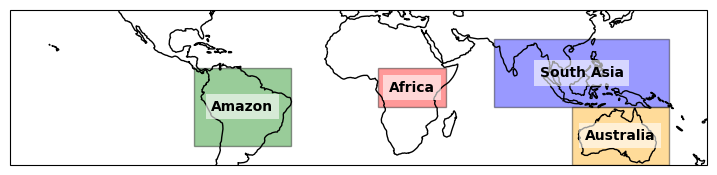

In [17]:
# Four typical geographical regions
regions_demo = {
    'Amazon':     {'lat': (-30, 10),  'lon': (275, 325), 'color': 'green'},   # Amazon rainforest region
    'Africa':     {'lat': (-10, 10), 'lon': (10, 45),   'color': 'red'},      # Equatorial Africa region
    'South Asia':  {'lat': (-10, 25), 'lon': (70, 160),  'color': 'blue'},     # South Asia region
    'Australia':  {'lat': (-40, -10),  'lon': (110, 160), 'color': 'orange'}, # Australian continent
}

fig = plt.figure(figsize=(9, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([1e-3, 359.999, -40, 40], crs=ccrs.PlateCarree())
ax.coastlines()

# plot area
for name, b in regions_demo.items():
    lat1, lat2 = b['lat']
    lon1, lon2 = b['lon']
    rect = Rectangle(
        (lon1, lat1), lon2 - lon1, lat2 - lat1,
        linewidth=1, edgecolor='k', facecolor=b['color'], alpha=0.4,
        transform=ccrs.PlateCarree()
    )
    ax.add_patch(rect)
    ax.text((lon1+lon2)/2, (lat1+lat2)/2, name,
            ha='center', va='center', fontsize=10, weight='bold',
            transform=ccrs.PlateCarree(),
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))


plt.savefig('GPP_ENSO_regions_demo.png', dpi=300, bbox_inches='tight')
plt.show()


# **step.5 Sensitivity attribution analysis: contributions from temperature and precipitation**

To understand why GPP sensitivity to ENSO changes under different scenarios, we analyzed the contributions of two key climatic factors: temperature (tas) and precipitation (pr).
Through this attribution analysis, we can better reveal how climate change—via temperature and precipitation—drives variations in terrestrial carbon flux sensitivity, and how geoengineering may mitigate the negative ecological impacts of ENSO events.

In [18]:
PR_ANNUAL_FILES = {
    'abrupt-4xCO2': 'pr_Amon_CanESM5_abrupt-4xCO2_185001-200012_1x1_1890-1949_detrend_annual_1890-1949.nc',
    'G1':           'pr_Amon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend_annual_1890-1949.nc',
}

TAS_ANNUAL_FILES = {
    'abrupt-4xCO2': 'tas_Amon_CanESM5_abrupt-4xCO2_185001-200012_1x1_1890-1949_detrend_annual_1890-1949.nc',
    'G1':           'tas_Amon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend_annual_1890-1949.nc',
}

## 5.1 Calculating the Climate Response (tos, pr) to ENSO

ENSO does not directly affect GPP. Instead, it first alters climate conditions (such as temperature and precipitation), and these climate changes then indirectly influence plant carbon uptake.
So we first calculate how strongly ENSO events impact temperature and precipitation (the sensitivity of tos and pr to ENSO).

In [19]:
# Calculate the response coefficients of precipitation and temperature to ENSO
def compute_climate_beta(var_name, file_dict, enso_indices):
    betas = {}
    for exp, path_name in file_dict.items():
        tmp = download_temp(base_url + path_name)
        ds = xr.open_dataset(tmp)
        da = ds[var_name]
        
        idx = 0 if exp == 'abrupt-4xCO2' else 1
        beta_field = calc_spatial_regression(da, enso_indices[idx, :])
        
        betas[exp] = xr.DataArray(
            beta_field,
            coords={'lat': da.lat, 'lon': da.lon},
            dims=('lat', 'lon')
        )
        
        ds.close()
        Path(tmp).unlink()
    return betas

beta_pr = compute_climate_beta('pr', PR_ANNUAL_FILES, ENSO_index)
beta_tas = compute_climate_beta('tas', TAS_ANNUAL_FILES, ENSO_index)

beta_pr_diff = beta_pr['G1'] - beta_pr['abrupt-4xCO2']
beta_tas_diff = beta_tas['G1'] - beta_tas['abrupt-4xCO2']

getfattr: /tmp/tmpvnwm1d6c.nc: Operation not supported
getfattr: /tmp/tmpqscky5zb.nc: Operation not supported
getfattr: /tmp/tmp688tstcc.nc: Operation not supported
getfattr: /tmp/tmpk60a4gqb.nc: Operation not supported


## 5.2 Calculating the sensitivity of GPP to climate factors (tos and pr)

Next, we calculate how strongly temperature and precipitation each affect GPP (the sensitivity of GPP to tos and pr).

In [21]:
# Calculate the response coefficients of GPP to precipitation and Temperature
results = {}
def multiple_regression_coeffs(y, x1, x2):
    mask = np.isfinite(y) & np.isfinite(x1) & np.isfinite(x2)
    if mask.sum() < 3:
        return np.nan, np.nan
    X = np.column_stack([np.ones(mask.sum()), x1[mask], x2[mask]])
    beta = np.linalg.lstsq(X, y[mask], rcond=None)[0]
    return beta[1], beta[2]

def grid_partial_regression(gpp_da, tas_da, pr_da):
    gpp, tas, pr = gpp_da.values, tas_da.values, pr_da.values
    t, nlat, nlon = gpp.shape
    beta_T = np.full((nlat, nlon), np.nan, dtype='float32')
    beta_P = np.full((nlat, nlon), np.nan, dtype='float32')
    for i in range(nlat):
        for j in range(nlon):
            if not (np.all(np.isnan(gpp[:,i,j])) or np.all(np.isnan(tas[:,i,j])) or np.all(np.isnan(pr[:,i,j]))):
                beta_T[i,j], beta_P[i,j] = multiple_regression_coeffs(gpp[:,i,j], tas[:,i,j], pr[:,i,j])
    return beta_T, beta_P

for exp in ['abrupt-4xCO2', 'G1']:
    gpp_da = GPP_annual[exp].sel(lat=LAT_SLICE)
    
    tas_da = xr.open_dataset(download_temp(base_url + TAS_ANNUAL_FILES[exp]))['tas'].sel(lat=LAT_SLICE)
    pr_da = xr.open_dataset(download_temp(base_url + PR_ANNUAL_FILES[exp]))['pr'].sel(lat=LAT_SLICE)
    
    bT, bP = grid_partial_regression(gpp_da, tas_da, pr_da)
    
    results[f'gamma_GPP_T_{exp}'] = xr.DataArray(bT, coords={'lat': gpp_da.lat, 'lon': gpp_da.lon}, dims=('lat','lon'))
    results[f'gamma_GPP_P_{exp}'] = xr.DataArray(bP, coords={'lat': gpp_da.lat, 'lon': gpp_da.lon}, dims=('lat','lon'))

results['gamma_GPP_T_diff'] = results['gamma_GPP_T_G1'] - results['gamma_GPP_T_abrupt-4xCO2']
results['gamma_GPP_P_diff'] = results['gamma_GPP_P_G1'] - results['gamma_GPP_P_abrupt-4xCO2']

getfattr: /tmp/tmpjf7lqeyc.nc: Operation not supported
getfattr: /tmp/tmp5hlqohsz.nc: Operation not supported
getfattr: /tmp/tmp_qparv6n.nc: Operation not supported
getfattr: /tmp/tmp92ne404d.nc: Operation not supported


### 5.3 Sensitivity Decomposition

Finally, we combine the two parts above and use an equation to decompose the sources of changes in GPP sensitivity to ENSO.

The fomula:
$$
\Delta\gamma_{\mathrm{GPP}}^{\mathrm{ENSO}} =
\Delta\gamma_{\mathrm{GPP}}^{\mathrm{Temp}}\gamma_{\mathrm{Temp}}^{\mathrm{ENSO}} + 
\Delta\gamma_{\mathrm{Temp}}^{\mathrm{ENSO}}\gamma_{\mathrm{GPP}}^{\mathrm{Temp}} +
\Delta\gamma_{\mathrm{GPP}}^{\mathrm{Prec}}\gamma_{\mathrm{Prec}}^{\mathrm{ENSO}} +
\Delta\gamma_{\mathrm{Prec}}^{\mathrm{ENSO}}\gamma_{\mathrm{GPP}}^{\mathrm{Prec}} +
\varepsilon
$$


In [22]:
#Decomposition Calculation

#Variables related to GPP
gamma_T_4x = results['gamma_GPP_T_abrupt-4xCO2']
gamma_P_4x = results['gamma_GPP_P_abrupt-4xCO2']
delta_gamma_T = results['gamma_GPP_T_diff']
delta_gamma_P = results['gamma_GPP_P_diff']

#Variables related to ENSO
beta_T_4x = beta_tas['abrupt-4xCO2']
beta_P_4x = beta_pr['abrupt-4xCO2']
delta_beta_T = beta_tas_diff
delta_beta_P = beta_pr_diff

term_a = delta_gamma_T * beta_T_4x # contribution from change in GPP–temperature sensitivity
term_b = gamma_T_4x * delta_beta_T # contribution from change in temperature–ENSO sensitivity
term_c = delta_gamma_P * beta_P_4x # contribution from change in GPP–precipitation sensitivity
term_d = gamma_P_4x * delta_beta_P# contribution from change in precipitation–ENSO sensitivity

term_e = term_a + term_b + term_c + term_d

print("done")

done


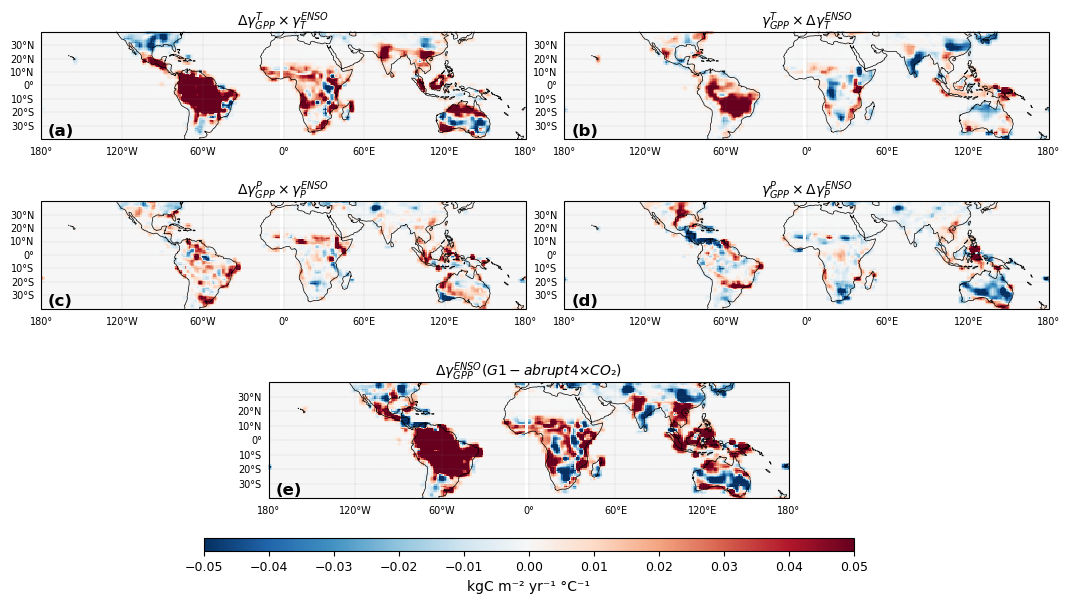

In [26]:
#Plot
def close_longitude(da): #Fix longitude seam for plotting
    lon_vals = da.lon.values
    dlon = np.diff(lon_vals).mean()
    new_lon = np.append(lon_vals, lon_vals[-1] + dlon)
    da_ext = xr.concat([da, da.isel(lon=0)], dim='lon')
    return da_ext.assign_coords(lon=new_lon)

def plot_panel(ax, da, title, letter):
    da_ext = close_longitude(da)
    im = ax.pcolormesh(
        da_ext.lon, da_ext.lat, da_ext,
        transform=ccrs.PlateCarree(),
        cmap='RdBu_r', vmin=-0.05, vmax=0.05, shading='auto'
    )
    ax.coastlines(linewidth=0.5)
    ax.set_extent([-180, 180, -40, 40], crs=ccrs.PlateCarree())
    ax.set_title(title, fontsize=10, pad=2)
    ax.text(-175, -37, f'({letter})', fontsize=12, fontweight='bold')
    
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.4, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 7}
    gl.ylabel_style = {'size': 7}
    return im

fig = plt.figure(figsize=(13, 6.5))
proj = ccrs.PlateCarree()

gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1], width_ratios=[1, 1], figure=fig)
gs.update(wspace=0.08, hspace=0.05)

axes = [
    fig.add_subplot(gs[0, 0], projection=proj),
    fig.add_subplot(gs[0, 1], projection=proj),
    fig.add_subplot(gs[1, 0], projection=proj),
    fig.add_subplot(gs[1, 1], projection=proj),
]

# Add bottom center panel (e)
ax_e = fig.add_axes([0.30, 0.08, 0.40, 0.26], projection=proj)
axes.append(ax_e)

#titles
titles = [
    r'$\Delta \gamma_{GPP}^T \times \gamma_T^{ENSO}$',
    r'$\gamma_{GPP}^T \times \Delta \gamma_T^{ENSO}$',
    r'$\Delta \gamma_{GPP}^P \times \gamma_P^{ENSO}$',
    r'$\gamma_{GPP}^P \times \Delta \gamma_P^{ENSO}$',
    r'$\Delta \gamma_{GPP}^{ENSO} (G1 - abrupt4×CO₂)$'
]
letters = ['a', 'b', 'c', 'd', 'e']
fields = [term_a, term_b, term_c, term_d, term_e]

# Plot all panels
for ax, da, t, l in zip(axes, fields, titles, letters):
    im = plot_panel(ax, da, t, l)

# colorbar
cbar_ax = fig.add_axes([0.25, 0.04, 0.5, 0.02])
cb = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', 
                  ticks=np.arange(-0.05, 0.051, 0.01))
cb.set_label(r'kgC m⁻² yr⁻¹ °C⁻¹', fontsize=10)
cb.ax.tick_params(labelsize=9)

# Save
plt.savefig('Delta_gamma_GPP_ENSO_decomposition.png', dpi=400, bbox_inches='tight')
plt.show()

This Figure  provides a deeper look into why geoengineering (G1) can reduce the sensitivity of terrestrial ecosystems (GPP) to ENSO. This change in sensitivity can be explained by two key factors: temperature and precipitation.

(a) and (b) show that temperature plays the main role in reducing sensitivity. The darkest areas—mainly in the Amazon, Central Africa, and Southeast Asia—indicate that under normal conditions, El Niño–related warming would greatly reduce plant productivity. However, in the G1 scenario, the impact of temperature rise is largely reduced, easing the climate stress on vegetation.

(c) and (d) show the contribution of precipitation changes to GPP sensitivity differences. Compared with temperature, this effect is smaller and more scattered. In some areas, such as Australia and parts of Southeast Asia, changes in rainfall also affect plant growth, but temperature remains the dominant factor overall.

(e) shows the total change in sensitivity, with the strongest combined effects again found in the Amazon, Central Africa, and Southeast Asia—regions where temperature effects largely drive the overall pattern.

**Conclusion**

Based on the analysis above, we conclude that:

Under high CO₂ conditions, ENSO events become more frequent and intense. Extreme climate events occur more often, significantly reducing the carbon uptake capacity of tropical ecosystems and making these ecosystems more vulnerable.

Solar Radiation Management (SRM) geoengineering (G1 scenario) can effectively reduce ENSO's impact on GPP.

Geoengineering mainly works by reducing the unusual warming caused by ENSO events (the temperature pathway), greatly decreasing the sensitivity of tropical ecosystems' carbon uptake to ENSO. This makes ecosystems more stable and better able to withstand climate disturbances from ENSO.

In short, our study clearly demonstrates that in a warming world, SRM geoengineering offers significant ecological benefits, particularly for tropical regions. It can effectively reduce the negative impacts of ENSO on global ecosystems.
